# TESS Background data

This notebook shows how to use `BackgroundCube` to get TESS Full Frame Images (FFI) scatter light component for every camera/ccd in the instrument.

This data could be used to correct the scatter light contribution in TESS FFI cutouts.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# basic imports
import os
import numpy as np
from tess_backml import BackgroundCube
import matplotlib.pyplot as plt

# increase animation frame limits
import matplotlib
matplotlib.rcParams["animation.embed_limit"] = 2**128

In [3]:
# define sector/camera/ccd
sector = 2
camera = 1
ccd = 1
binsize = 8

## Initialize
We initialize the object with a specific Sectopr/Camera/CCD, an image bin size, and a method for downsizing (default if 'binning')

In [4]:
bkg_data = BackgroundCube(
    sector=sector, camera=camera, ccd=ccd, img_bin=binsize, downsize="binning"
)
print(bkg_data)

TESS FFI Background object (Sector, Camera, CCD, N times): 2, 1, 1, 1235


## Get Flux Data
Compute the binned scatter light cube which does:
- Finds the darkest frame in the sector to build a star mask and a saturated pixel mask
- Adds a strap mask
- Pulls the FFI flux data from the cloud
- Downsize the image by doing median 8x8 (effective) binning, masking out stars, straps, and saturated pixels
    - If `rolling=True` downsizing is done with iterative rolling windows to get to the desired output shape, this will increase ~25% more the computing time, but will give more robust estimations around bright stars, saturated pixes, and straps.
- The resulting scatter light cube has shape [nt, 256, 256]

Note: this is the most time consuming step, most of the computing time is spend in I/O (~50-60% of each iteration). This can be speed up if we run this notebook in TIKE and take advantage of AWS, if that's the case, a typical Sector/Camera/CCD should take ~30-40 minutes, depending of load. In a local machine, it can take up to 1h depending on internet connection.

INFO:tess_backml:Computing sector darkest frames...
INFO:tess_backml:Computing star mask...


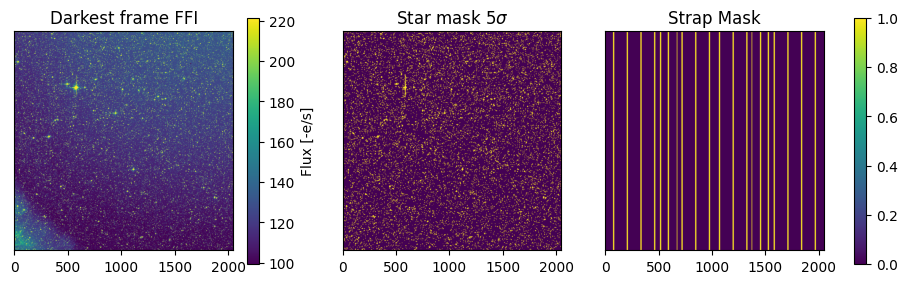

INFO:tess_backml:Getting FFI flux cube...
INFO:tess_backml:Computing average static scene from darkes frames...


Iterating frames: 100%|██████████| 1245/1245 [44:38<00:00,  2.15s/it]


89
INFO:tess_backml:Filling nans with interpolation...


100%|██████████| 1235/1235 [00:20<00:00, 60.77it/s]


In [5]:
bkg_data.get_scatter_light_cube(frames=None, mask_straps=True, plot=True, rolling=True, errors=True)

We can animate the scatter light cube for visualization

In [6]:
bkg_data.animate_data(data="sl", save=False, step=10);

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


## Time binning

We can do time binning to reduce size of the cubes and save memory/storage. The function `bkg_data.bin_time_axis()` takes the parameter `bin_size` as the size of the bin in hours.
This creates new attributes (e.g. `bkg_data.time_bin` and `bkg_data.scatter_cube_bin`)

In [7]:
bkg_data.bin_time_axis(bin_size=2.0)
bkg_data.time_bin.shape, bkg_data.scatter_cube_bin.shape

((312,), (312, 256, 256))

## Save Data
Save only the scatter light cube in its binned version to a `FITS` file.

In [8]:
fname = f"./data/ffi_cubes_sector{sector:03}_{camera}-{ccd}_light.fits"
print(fname)
_ = bkg_data.save_to_fits(out_file=fname, binned=True)

./data/ffi_cubes_sector002_1-1_light.fits


In [9]:
from astropy.io import fits

In [10]:
hdul = fits.open(fname)
hdul.info()

Filename: ./data/ffi_cubes_sector002_1-1_light.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      62   ()      
  1  SCATTER LIGHT CUBE    1 ImageHDU        10   (2, 312, 256, 256)   float64   
  2  PIXEL COUNTS    1 ImageHDU         8   (256, 256)   int64   
  3  TIME          1 BinTableHDU     13   312R x 1C   [D]   
